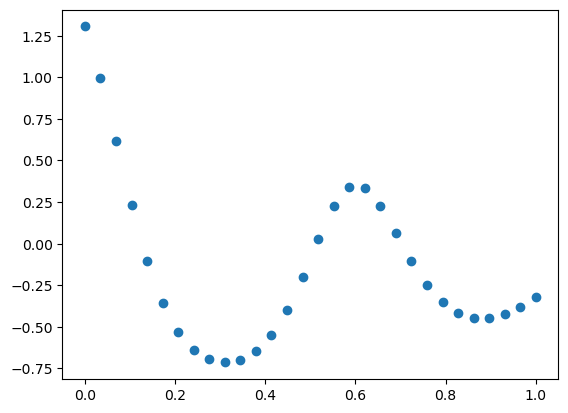

In [27]:
import numpy as np
import GPy
import matplotlib.pyplot as plt
from known_boundary.SLogGP import SLogGP

np.random.seed(0)


X_init = np.array([0.0]).reshape(-1,1)
Y_init = np.array([0.0]).reshape(-1,1)

kernel = GPy.kern.RBF(input_dim=1,lengthscale= 0.2,variance=0.5)  #np.sqrt(res[0])
model_test = GPy.models.GPRegression(X_init, Y_init,kernel)

X_test = np.linspace(0,1,30).reshape(-1,1)
Y_test = np.exp(0.5+model_test.posterior_samples_f(X_test,size=1).reshape(-1,1))-1

plt.scatter(X_test,Y_test)

In [28]:
from known_boundary.utlis import  get_initial_points,transform,opt_model_MLE
opt_model_MLE(X_test,Y_test,1,'SLogGP',noise=1e-6,seed=1234,lengthscale_range=[0.01,1],variance_range=[0.01**2,10],c_range=[0.78,10]) 

[0.23025149587653634, 1.313433486874737, 0.9909693992399653]

In [29]:
lower = -np.min(Y_test)+10**(-6)
upper = lower+5

m = GPy.models.WarpedGP(X_test, Y_test,warping_function=SLogGP(lower=lower,upper=upper,n_terms =1))
m.rbf.lengthscale.constrain_bounded(0.01,10)
m.rbf.variance.constrain_bounded(0.01**2,10)
m.Gaussian_noise.fix(1e-6)
parameter_num = 3

for i in range(parameter_num**3):
    try:
        np.random.seed(i)
        m.optimize()
    except:
        print('oh')
        pass

In [30]:
m

gp.,value,constraints,priors
rbf.variance,1.3134625796354569,"0.0001,10.0",
rbf.lengthscale,0.23025187379070672,"0.01,10.0",
Gaussian_noise.variance,1e-06,+ve fixed,
SlogGP.psi,[0.99096939],"0.7138615543306269,5.713861554330627",


now lower bound is:  -0.3222856938177987


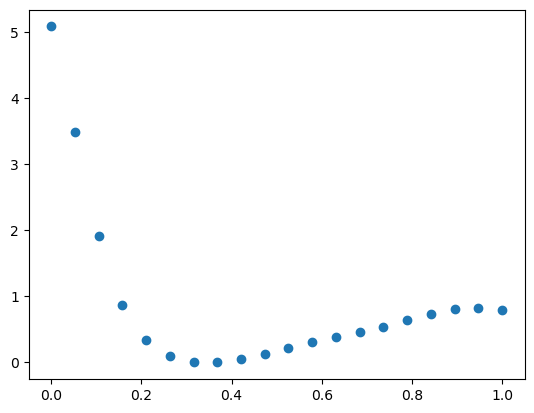

In [31]:
np.random.seed(0)


X_init = np.array([0.0]).reshape(-1,1)
Y_init = np.array([0.0]).reshape(-1,1)

kernel = GPy.kern.RBF(input_dim=1,lengthscale= 0.2,variance=0.5)  #np.sqrt(res[0])
model_test = GPy.models.GPRegression(X_init, Y_init,kernel)

X_test = np.linspace(0,1,20).reshape(-1,1)
Y_test = np.exp(0.5+model_test.posterior_samples_f(X_test,size=1).reshape(-1,1))-1

print('now lower bound is: ',-1- np.min(Y_test))
Y_test = Y_test - np.min(Y_test)
plt.scatter(X_test,Y_test)

In [32]:
m = GPy.models.WarpedGP(X_test, Y_test,warping_function=SLogGP(lower=0,upper=0,n_terms =1,psi_bound = False))
m.rbf.lengthscale.constrain_bounded(0.01,10)
m.rbf.variance.constrain_bounded(0.01**2,10)
m.Gaussian_noise.fix(1e-6)
parameter_num = 3

for i in range(parameter_num**3):
    try:
        np.random.seed(i)
        m.optimize()
    except:
        print('oh')
        pass

In [33]:
m

gp.,value,constraints,priors
rbf.variance,1.055365715433419,"0.0001,10.0",
rbf.lengthscale,0.23109137766196602,"0.01,10.0",
Gaussian_noise.variance,1e-06,+ve fixed,
SlogGP.psi,[0.34705233],+ve,


In [34]:
prior = GPy.priors.LogGaussian(mu=0, sigma=0.25)
m = GPy.models.WarpedGP(X_test, Y_test,warping_function=SLogGP(lower=0,upper=0,n_terms =1,psi_bound = False))
m.rbf.lengthscale.constrain_bounded(0.01,10)
m.rbf.variance.constrain_bounded(0.01**2,10)
m.Gaussian_noise.fix(1e-6)
parameter_num = 3
m.SlogGP.psi.set_prior(prior, warning=False)


for i in range(parameter_num**3):
    try:
        np.random.seed(i)
        m.optimize()
    except:
        print('oh')
        pass

In [35]:
m

gp.,value,constraints,priors
rbf.variance,1.0597686477043688,"0.0001,10.0",
rbf.lengthscale,0.23168655441329503,"0.01,10.0",
Gaussian_noise.variance,1e-06,+ve fixed,
SlogGP.psi,[0.35621605],+ve,"lnN(0, 0.25)"


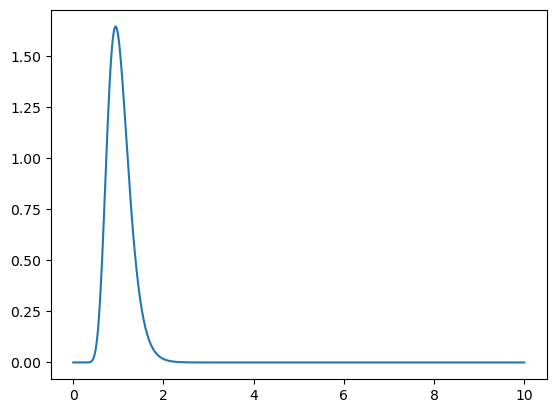

In [21]:
from scipy import stats
import math 

pdf_function = stats.lognorm(s=0.25, scale=math.exp(0))

X_total = np.linspace(0,10,500) 
pdf_holder = []
for x in X_total:
    res = pdf_function.pdf(x)
    pdf_holder.append(res)

plt.plot(X_total,np.array(pdf_holder))

# artifical function try

In [22]:
import botorch
from known_boundary.acquisition_function import EI_acquisition_opt,SLogTEI_acquisition_opt,SLogEI_acquisition_opt
from known_boundary.utlis import  get_initial_points,transform,opt_model_MLE
import numpy as np
import GPy
import torch
from botorch.test_functions import Ackley,Levy,Beale,Branin,Hartmann,Rosenbrock,Powell,SixHumpCamel
from botorch.utils.transforms import unnormalize,normalize
from known_boundary.SLogGP import SLogGP
import scipy 

import warnings
warnings.filterwarnings("ignore")
import logging
logging.getLogger('lengthscale').disabled = True
logging.getLogger('variance').disabled = True
logging.getLogger('psi').disabled = True


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
dtype = torch.double


In [55]:
lengthscale_range = [0.01,1]
variance_range = [0.01**2,10]
noise = 1e-6

In [56]:
fun = Branin(negate=False)

dim = fun.dim
bounds = fun.bounds
standard_bounds=np.array([0.,1.]*dim).reshape(-1,2)

if dim <=3:
    step_size = 2
elif dim<=7:
    step_size = 3
else:
    step_size = 4
    
n_init = 4*dim
iter_num = 50
N = 20

fstar = 0.397887


In [85]:
for exp in range(1):

    seed = exp
    
    print(exp)

    X_BO = get_initial_points(bounds, n_init,device,dtype,seed=seed)
    Y_BO = torch.tensor(
        [fun(x) for x in X_BO], dtype=dtype, device=device
    ).reshape(-1,1)



    best_record = [Y_BO.min().item()]
    print(best_record[-1])
    np.random.seed(1234)

    for i in range(50):

            print('inner loop: ',i)
        
            train_Y = Y_BO.numpy()
            fstar_shifted = fstar - np.min(train_Y)  # shifted lower bound
            print('shift lower bound: ',fstar_shifted)
            train_Y = train_Y - np.min(train_Y)
            train_X = normalize(X_BO, bounds)
            train_X = train_X.numpy()
    
            
            train_Y_std = np.std(train_Y)
            lower = -np.min(train_Y)+10**(-6)
            upper = lower+min(300,5*train_Y_std)
            
            c_range = [lower,upper]
            
            if i%step_size == 0:
                
                parameter_num = 3
                restart_num = int(3**parameter_num/1)+1
                
                obj_holder = []
                parameter_holder = []
                
                for ii in range(restart_num):
                    
                    np.random.seed(ii)
                    
                    lengthscale_init = np.random.uniform(lengthscale_range[0],lengthscale_range[1],1)[0]
                    variance_init = np.random.uniform(variance_range[0],variance_range[1],1)[0]
                    c_init = np.random.uniform(c_range[0],c_range[1],1)[0]
                    
                    prior = GPy.priors.LogGaussian(mu=np.log(-fstar_shifted)+0.3**2, sigma=0.3) ########## prior
                    
                    m = GPy.models.WarpedGP(train_X.reshape(-1,dim), train_Y.reshape(-1,1),warping_function=SLogGP(lower=c_range[0],upper=c_range[1],n_terms =1,psi_bound = False))
                    m.SlogGP.psi.set_prior(prior, warning=False) ########## prior
                    
                    m.rbf.lengthscale = lengthscale_init
                    m.rbf.variance = variance_init
                    m.SlogGP.psi = c_init
                    
                    m.rbf.lengthscale.constrain_bounded(lengthscale_range[0],lengthscale_range[1])
                    m.rbf.variance.constrain_bounded(variance_range[0],variance_range[1])
                    m.Gaussian_noise.fix(noise) 
                    
                    m.optimize()
                    
                    obj_temp = -m.log_likelihood()
                    lengthscale_temp = m.rbf.lengthscale.item()
                    variance_temp = m.rbf.variance.item()
                    c_temp = m.SlogGP.psi.item()
                    
                    obj_holder.append(obj_temp)
                    parameter_holder.append([lengthscale_temp,variance_temp,c_temp])
                    
                index = np.argmin(obj_holder)
                best_parameter = parameter_holder[index]
                

    
                lengthscale = best_parameter[0]
                variance = best_parameter[1]
                c = best_parameter[2]
                
                print('lengthscale: ',lengthscale)
                print('variance: ',variance)
                print('c: ',c)
            
            
            warp_Y = np.log(train_Y+c)
            mean_warp_Y = np.mean(warp_Y) # use to predict mean
            warp_Y_standard = warp_Y-mean_warp_Y
            
            
            kernel = GPy.kern.RBF(input_dim=dim,lengthscale= lengthscale,variance=variance)  
            m = GPy.models.GPRegression(train_X, warp_Y_standard,kernel)
            m.Gaussian_noise.variance.fix(noise)
            
            standard_next_X = SLogEI_acquisition_opt(model=m,bounds=standard_bounds,f_best=np.min(train_Y),c=c,f_mean=mean_warp_Y)
            X_next = unnormalize(torch.tensor(standard_next_X), bounds).reshape(-1,dim)            
            Y_next = fun(X_next).reshape(-1,1)
            
            # print('x chosen: ',X_next)
            # print('Y: ', Y_next)

            # Append data
            X_BO = torch.cat((X_BO, X_next), dim=0)
            Y_BO = torch.cat((Y_BO, Y_next), dim=0)
            
            best_record.append(Y_BO.min().item())
            print('!!!!!!!!!!best so far: ',best_record[-1])
            
    best_record = np.array(best_record)         


0
3.5451968551073154
inner loop:  0
shift lower bound:  -3.1473098551073155
lengthscale:  0.2633949211038546
variance:  1.1964853341052757
c:  3.4771665200334323
!!!!!!!!!!best so far:  3.5451968551073154
inner loop:  1
shift lower bound:  -3.1473098551073155
!!!!!!!!!!best so far:  3.5451968551073154
inner loop:  2
shift lower bound:  -3.1473098551073155
lengthscale:  0.09133557219826206
variance:  0.9533282238920574
c:  3.377060711016912
!!!!!!!!!!best so far:  2.096143012447545
inner loop:  3
shift lower bound:  -1.698256012447545
!!!!!!!!!!best so far:  2.096143012447545
inner loop:  4
shift lower bound:  -1.698256012447545
lengthscale:  0.08282975440749825
variance:  1.3473146432367091
c:  1.8749447133511925
!!!!!!!!!!best so far:  0.983815127962405
inner loop:  5
shift lower bound:  -0.585928127962405
!!!!!!!!!!best so far:  0.8835022764339637
inner loop:  6
shift lower bound:  -0.48561527643396374
lengthscale:  0.06023390763605218
variance:  2.393565886611064
c:  0.5380767409968

In [80]:
# enforce the boundary
best_record

array([3.54519686, 3.54519686, 3.54519686, 2.09512436, 2.09512436,
       1.1813443 , 0.89090841, 0.79172825, 0.5265024 , 0.50493566,
       0.50493566, 0.50493566, 0.50493566, 0.47913056, 0.47913056,
       0.47913056, 0.47913056, 0.47913056, 0.47913056, 0.47913056,
       0.47913056, 0.47913056, 0.47913056, 0.47913056, 0.47913056,
       0.47913056, 0.47913056, 0.47913056, 0.47913056, 0.47913056,
       0.47913056, 0.47913056, 0.47913056, 0.47913056, 0.42776952,
       0.42776952, 0.42776952, 0.42776952, 0.42776952, 0.42776952,
       0.42776952, 0.42776952, 0.42776952, 0.42776952, 0.42776952,
       0.42776952, 0.42776952, 0.42776952, 0.42776952, 0.42776952,
       0.42776952])

In [86]:
# sigma = 0.3
best_record

array([3.54519686, 3.54519686, 3.54519686, 2.09614301, 2.09614301,
       0.98381513, 0.88350228, 0.84981672, 0.49093137, 0.49093137,
       0.49093137, 0.49093137, 0.49093137, 0.49093137, 0.41768172,
       0.41768172, 0.41768172, 0.4098238 , 0.39850712, 0.39850712,
       0.39850712, 0.39850712, 0.39850712, 0.39850712, 0.39850712,
       0.39850712, 0.39850712, 0.39850712, 0.39850712, 0.39850712,
       0.39850712, 0.39850712, 0.39850712, 0.39850712, 0.39850712,
       0.39850712, 0.39850712, 0.39850712, 0.39850712, 0.39850712,
       0.39850712, 0.39850712, 0.39850712, 0.39850712, 0.39850712,
       0.39850712, 0.39850712, 0.39850712, 0.39850712, 0.39850712,
       0.39850712])

In [84]:
# sigma = 1
best_record

array([3.54519686, 3.54519686, 3.54519686, 0.70990423, 0.70990423,
       0.70990423, 0.69210527, 0.69210527, 0.69210527, 0.69210527,
       0.69210527, 0.69210527, 0.61635434, 0.61635434, 0.61635434,
       0.48115369, 0.48115369, 0.48115369, 0.48115369, 0.48115369,
       0.48115369, 0.48115369, 0.48115369, 0.48115369, 0.48115369,
       0.48115369, 0.39864212, 0.39864212, 0.39864212, 0.39864212,
       0.39864212, 0.39864212, 0.39864212, 0.39864212, 0.39864212,
       0.39864212, 0.39864212, 0.39864212, 0.39864212, 0.39864212,
       0.39835139, 0.39835139, 0.39835139, 0.39835139, 0.39835139,
       0.39805497, 0.39805497, 0.39792541, 0.39792541, 0.39792541,
       0.39792541])

In [71]:
SLogEI_noboundary = []

for exp in range(1):

    seed = 1
    
    print(exp)

    X_BO = get_initial_points(bounds, n_init,device,dtype,seed=seed)
    Y_BO = torch.tensor(
        [fun(x) for x in X_BO], dtype=dtype, device=device
    ).reshape(-1,1)



    best_record = [Y_BO.min().item()]
    np.random.seed(1234)

    for i in range(iter_num):

            #print('inner loop: ',i)
        
            train_Y = Y_BO.numpy()
            train_Y = train_Y-np.min(train_Y)
            train_X = normalize(X_BO, bounds)
            train_X = train_X.numpy()
            
            train_Y_std = np.std(train_Y)
            lower = -np.min(train_Y)+10**(-6)
            upper = lower+min(300,5*train_Y_std)
            
            c_range = [lower,upper]

            if i%step_size == 0:
                
                parameters = opt_model_MLE(train_X,train_Y,dim,'SLogGP',noise=noise,lengthscale_range=lengthscale_range,variance_range=variance_range,c_range=c_range)                
    
                lengthscale = parameters[0]
                variance = parameters[1]
                c = parameters[2]
                
                print('lengthscale is ',lengthscale)
                print('variance is ',variance)
                print('c is ',c)
            
            
            warp_Y = np.log(train_Y+c)
            mean_warp_Y = np.mean(warp_Y) # use to predict mean
            warp_Y_standard = warp_Y-mean_warp_Y
            
            
            kernel = GPy.kern.RBF(input_dim=dim,lengthscale= lengthscale,variance=variance)  
            m = GPy.models.GPRegression(train_X, warp_Y_standard,kernel)
            m.Gaussian_noise.variance.fix(noise)
            
            standard_next_X = SLogEI_acquisition_opt(model=m,bounds=standard_bounds,f_best=np.min(train_Y),c=c,f_mean=mean_warp_Y)
            X_next = unnormalize(torch.tensor(standard_next_X), bounds).reshape(-1,dim)            
            Y_next = fun(X_next).reshape(-1,1)

            # Append data
            X_BO = torch.cat((X_BO, X_next), dim=0)
            Y_BO = torch.cat((Y_BO, Y_next), dim=0)
            
            best_record.append(Y_BO.min().item())
            print(best_record[-1])
            
    best_record = np.array(best_record)         
    SLogEI_noboundary.append(best_record)

0
lengthscale is  0.22333376236854166
variance is  9.999999871994998
c is  0.00012785996268437785
5.472660418879451
0.532009156228872
lengthscale is  0.4056351585638274
variance is  2.982315748679596
c is  3.391061247709555
0.532009156228872
0.532009156228872
lengthscale is  0.1651084225909103
variance is  1.0116896302543923
c is  6.736440204568611
0.532009156228872
0.532009156228872
lengthscale is  0.08703721057960209
variance is  1.2710378135168332
c is  3.04781305499649
0.532009156228872
0.532009156228872
lengthscale is  0.14681384236611925
variance is  0.6877463290146975
c is  15.35226663540659
0.532009156228872
0.532009156228872
lengthscale is  0.036155140675611507
variance is  2.9848373860496205
c is  0.15160147528764129
0.4079051474225981
0.4079051474225981
lengthscale is  0.1686878764812053
variance is  0.6676777147185083
c is  18.878036750117328
0.4079051474225981
0.4079051474225981
lengthscale is  0.16869199585851116
variance is  0.6123304538060623
c is  19.4348604271111
0.40